In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

In [2]:
NUM_TRIALS = 3
FOLDS = 5
DATA_SIZE = 1000 #5000

In [3]:
adults = pd.read_csv('data/adults/adult.data', header=None)

adults.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', '50k_plus']

adults

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,50k_plus
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
adults['sex'] = (adults['sex'] == 'Male').astype(int)
adults.rename(columns={'sex':'male'}, inplace=True)

adults['50k_plus'] = (adults['50k_plus'] == ' >50K').astype(int)
adults.rename(columns={'50k_plus':'y'}, inplace=True)

adults = pd.get_dummies(adults, columns=['workclass', 'education', 'marital_status', 'occupation','relationship', 'race', 'native_country'])
adults

,age,fnlwgt,education_num,male,capital_gain,capital_loss,hours_per_week,y,workclass_ ?,workclass_ Federal-gov,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,39,77516,13,0,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,0,38,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,0,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,0,0,0,20,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# adults.columns.values
adults.isna().values.any() # OK!!

False

In [6]:
adults

,age,fnlwgt,education_num,male,capital_gain,capital_loss,hours_per_week,y,workclass_ ?,workclass_ Federal-gov,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,39,77516,13,0,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,0,38,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,0,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,0,0,0,20,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
# continuous
# cont_cols = np.asarray(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'])
cont_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# for col in cont_cols:
#     plt.figure()
#     plt.title(col)
#     plt.hist(adults[col])
    
col_names = adults.columns

mask = np.isin(col_names, cont_cols, invert=True)
non_cont = col_names[mask]

all_col = np.concatenate((cont_cols, non_cont))
adults = adults[all_col]

col_names = adults.columns

features = adults[col_names]

ct = ColumnTransformer([
    ('adult_continuous', preprocessing.StandardScaler(), cont_cols)
], remainder='passthrough')


# scaler.mean_
X_scaled = ct.fit_transform(features)
adults_processed = pd.DataFrame(X_scaled, columns=col_names)
adults_processed


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,male,y,workclass_ ?,workclass_ Federal-gov,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849080,0.639741,0.746039,-0.145920,-0.21666,-0.197409,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32557,0.103983,-0.335433,-0.420060,-0.145920,-0.21666,-0.035429,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32558,1.423610,-0.358777,-0.420060,-0.145920,-0.21666,-0.035429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32559,-1.215643,0.110960,-0.420060,-0.145920,-0.21666,-1.655225,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
adults_shuffle = adults_processed.sample(frac=1).reset_index(drop=True)
adults_shuffle_y = pd.DataFrame(adults_shuffle['y'])
adults_shuffle = adults_shuffle.drop('y', 1)

adults_training = adults_shuffle.iloc[:DATA_SIZE,:]
adults_training_y = adults_shuffle_y.iloc[:DATA_SIZE,:]
adults_testing = adults_shuffle.iloc[DATA_SIZE:,:]
adults_testing_y = adults_shuffle_y.iloc[DATA_SIZE:,:]

print(adults_training.shape)
print(adults_training_y.shape)
print(adults_testing.shape)
print(adults_testing_y.shape)
adults_training_y['y'].shape

(1000, 107)
(1000, 1)
(31561, 107)
(31561, 1)


(1000,)

Trial 0...
{'C': 100, 'gamma': 0.01}
[191 163]
Trial 1...
{'C': 10, 'gamma': 0.01}
[197 189]
Trial 2...
{'C': 10, 'gamma': 0.01}
[197 189]
Average difference of 0.006667 with std. dev. of 0.003300.


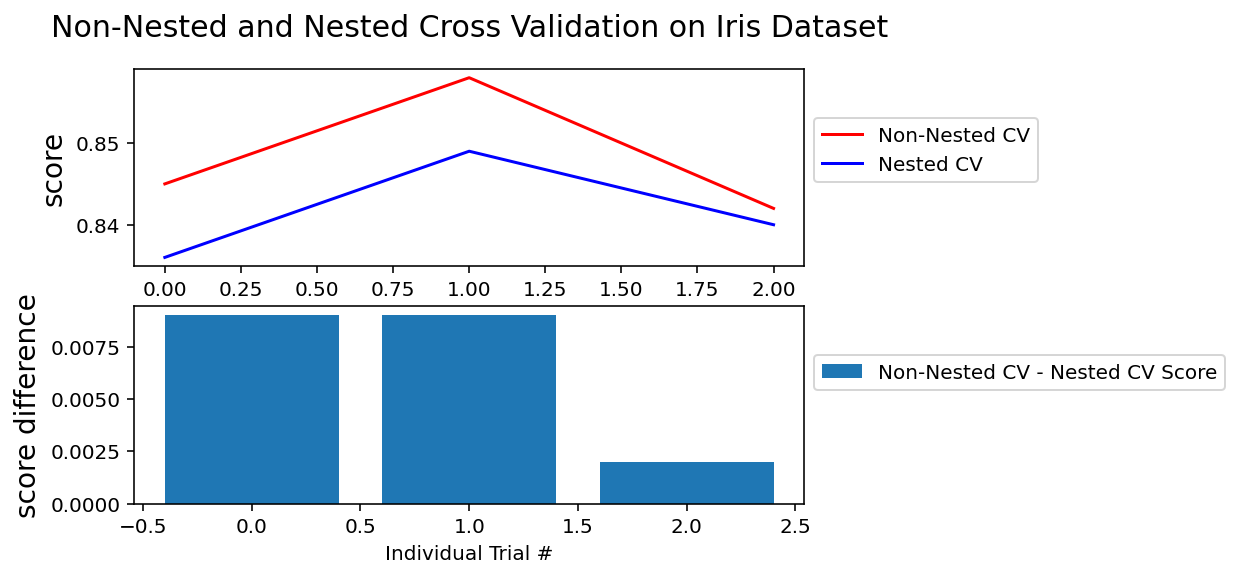

CPU times: user 3.18 s, sys: 244 ms, total: 3.42 s
Wall time: 19.9 s


In [18]:
%%time

features = adults_training.columns
X = adults_training.loc[:, features]
y = adults_training_y['y']

p_grid = {'C': [1,10,100,1000], 'gamma': [0.001,0.01,0.1,1.0]}

svm = SVC(kernel='rbf')

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):
    print('Trial {}...'.format(i))
    inner_cv = KFold(n_splits=FOLDS, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=FOLDS, shuffle=True, random_state=i)
    
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv, verbose=0, n_jobs=7)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_
    print(clf.best_params_)
    print(clf.best_estimator_.n_support_)
    
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    
score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(1, 0, 0, .8)) #(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(1, 0, 0, .8))
plt.ylabel("score difference", fontsize="14")

plt.show()

In [10]:
# for col in adults.columns:
#     print(col)
# adults.describe()

In [11]:
nested_scores

array([0.836, 0.849, 0.84 ])

In [12]:
non_nested_scores

array([0.845, 0.858, 0.842])

In [14]:
KFold(n_splits=FOLDS, shuffle=True, random_state=i)

KFold(n_splits=5, random_state=2, shuffle=True)